In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline

from bs4 import BeautifulSoup  
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk import sent_tokenize, word_tokenize, pos_tag

import logging
from gensim.models import word2vec
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

#from keras.preprocessing import sequence
#from keras.utils import np_utils
# from keras.models import Sequential
# from keras.layers.core import Dense, Dropout, Activation, Lambda
#from keras.layers.embeddings import Embedding
#from keras.layers.recurrent import LSTM, SimpleRNN, GRU
# from keras.preprocessing.text import Tokenizer
# #from collections import defaultdict
# from keras.layers.convolutional import Convolution1D
# from keras import backend as K
# from keras.layers.embeddings import Embedding
# Load csv file
df = pd.read_csv('Amazon_Unlocked_Mobile.csv')
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [3]:

print("\nTotal number of reviews: ",len(df))
print("\nTotal number of brands: ", len(list(set(df['Brand Name']))))
print("\nTotal number of unique products: ", len(list(set(df['Product Name']))))

print("\nPercentage of reviews with neutral sentiment : {:.2f}%"\
      .format(df[df['Rating']==3]["Reviews"].count()/len(df)*100))
print("\nPercentage of reviews with positive sentiment : {:.2f}%"\
      .format(df[df['Rating']>3]["Reviews"].count()/len(df)*100))
print("\nPercentage of reviews with negative sentiment : {:.2f}%"\
      .format(df[df['Rating']<3]["Reviews"].count()/len(df)*100))


Total number of reviews:  413840

Total number of brands:  385

Total number of unique products:  4410

Percentage of reviews with neutral sentiment : 7.68%

Percentage of reviews with positive sentiment : 68.86%

Percentage of reviews with negative sentiment : 23.45%


Text(0, 0.5, 'Count')

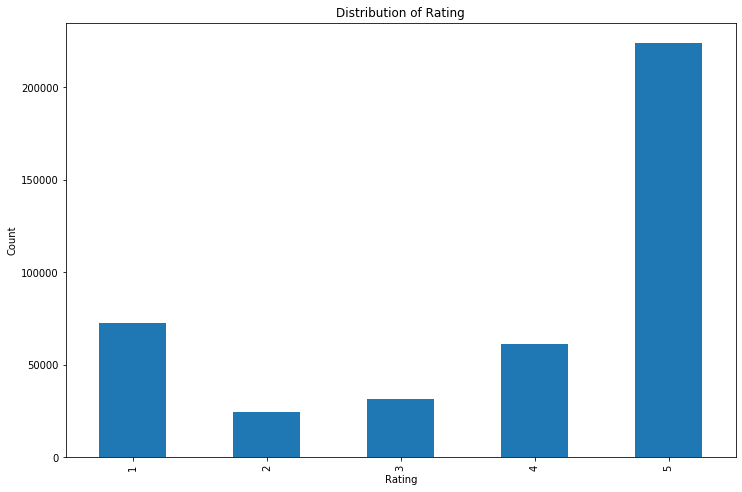

In [9]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

Text(0.5, 1.0, 'Number of Reviews for Top 20 Brands')

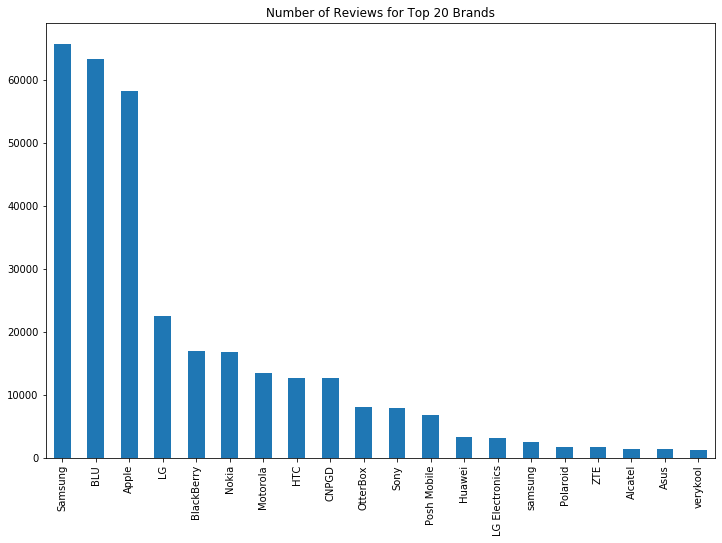

In [4]:
# Plot number of reviews for top 20 brands
brands = df["Brand Name"].value_counts()
# brands.count()
plt.figure(figsize=(12,8))
brands[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 20 Brands")

Text(0.5, 1.0, 'Number of Reviews for Top 50 Products')

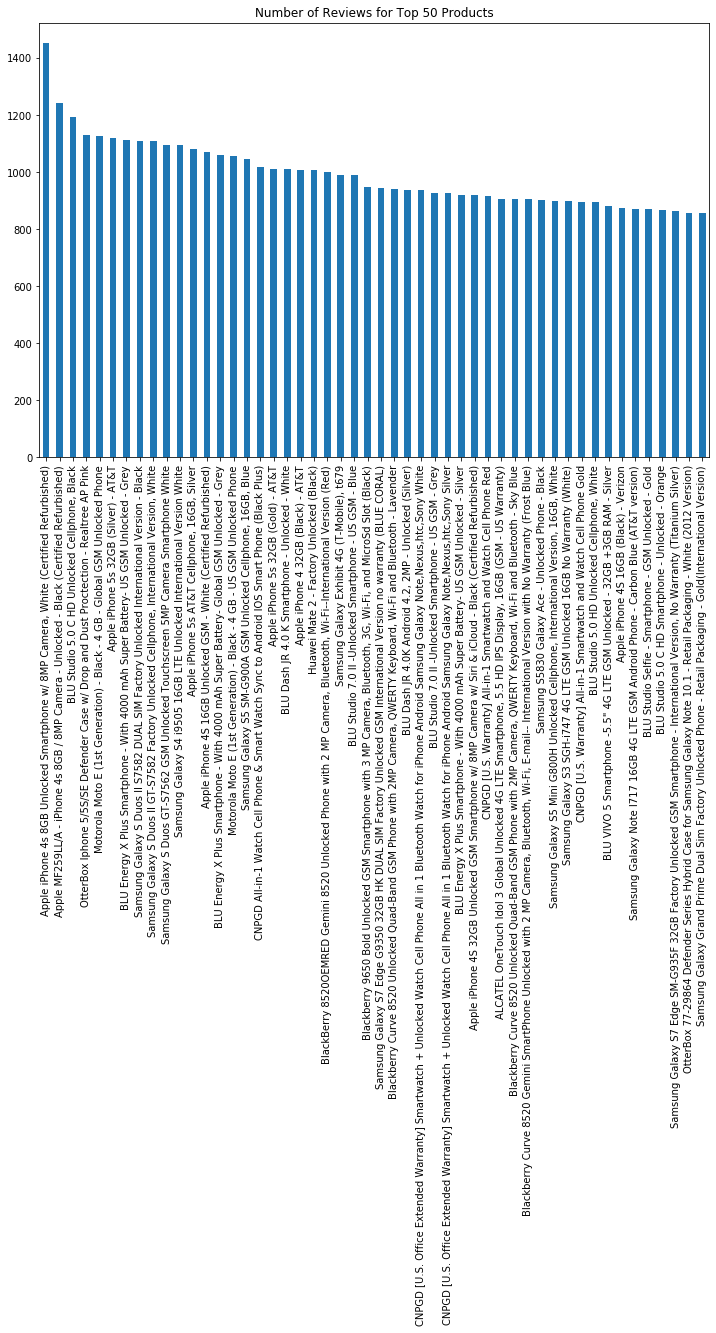

In [5]:
# Plot number of reviews for top 50 products
products = df["Product Name"].value_counts()
plt.figure(figsize=(12,8))
products[:50].plot(kind='bar')
plt.title("Number of Reviews for Top 50 Products")

In [6]:
df = df.sample(frac=0.1, random_state=0) #uncomment to use full set of data

# Drop missing values
df.dropna(inplace=True)

# Remove any 'neutral' ratings equal to 3
df = df[df['Rating'] != 3]

# Encode 4s and 5s as 1 (positive sentiment) and 1s and 2s as 0 (negative sentiment)
df['Sentiment'] = np.where(df['Rating'] > 3, 1, 0)
df.head()

,Product Name,Brand Name,Price,Rating,Reviews,Review Votes,Sentiment
134801,BLU Studio 5.0 C HD - Unlocked Cell Phones - R...,BLU,2000.00,5,"For the price I paid for this devices, its fan...",0.0,1
123493,Blu LIFE 8 Unlocked (Pink),BLU,199.98,5,love love love it....good buy...recommend to a...,0.0,1
335592,Samsung Galaxy S Duos II S7582 DUAL SIM Factor...,Samsung,299.99,4,Good,0.0,1
246353,"Motorola Droid 2 A955 Verizon Phone 5MP Cam, W...",Motorola,82.00,1,Not good. Returned first phone and they sent m...,0.0,0
273324,Nokia Lumia 920 32GB Unlocked GSM 4G LTE Windo...,Nokia,149.35,4,Met expectations! I'm very satisfied!Even arri...,1.0,1


In [12]:
# Split data into training set and validation
X_train, X_test, y_train, y_test = train_test_split(df['Reviews'], df['Sentiment'], \
                                                    test_size=0.1, random_state=0)

print('Load %d training examples and %d validation examples. \n' %(X_train.shape[0],X_test.shape[0]))
print('Show a review in the training set : \n', X_train.iloc[10])

Load 27799 training examples and 3089 validation examples. 

Show a review in the training set : 
 good product and fast shipping. thank you.


In [15]:
def cleanText(raw_text, remove_stopwords=False, stemming=False, split_text=False, \
             ):
    '''
    Convert a raw review to a cleaned review
    '''
    text = BeautifulSoup(raw_text).get_text()  #remove html
    letters_only = re.sub("[^a-zA-Z]", " ", text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    if remove_stopwords: # remove stopword
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
        
    if stemming==True: # stemming
#         stemmer = PorterStemmer()
        stemmer = SnowballStemmer('english') 
        words = [stemmer.stem(w) for w in words]
        
    if split_text==True:  # split text
        return (words)
    
    return( " ".join(words))

In [15]:
# Preprocess text data in training set and validation set
X_train_cleaned = []
X_test_cleaned = []

for d in X_train:
    X_train_cleaned.append(cleanText(d))
print('Show a cleaned review in the training set : \n',  X_train_cleaned[10])
    
for d in X_test:
    X_test_cleaned.append(cleanText(d))

c:\users\sreekala\appdata\local\programs\python\python37-32\lib\site-packages\bs4\__init__.py:375: UserWarning: "http://www.amazon.com/gp/product/B013YDFH3Y?redirect=true&ref_=cm_cr_ryp_prd_ttl_sol_0" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
c:\users\sreekala\appdata\local\programs\python\python37-32\lib\site-packages\bs4\__init__.py:375: UserWarning: "https://www.amazon.com/dp/B00K15KRV6/ref=cm_cr_ryp_prd_ttl_sol_22" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
c:\users\sreekala\appdata\local\programs\python\python37-32\lib\site-packages\bs4\__init__.py:375: UserWarning: "http://www.amazon.com/

Show a cleaned review in the training set : 
 good product and fast shipping thank you


In [16]:
# Fit and transform the training data to a document-term matrix using CountVectorizer
countVect = CountVectorizer() 
X_train_countVect = countVect.fit_transform(X_train_cleaned)
print("Number of features : %d \n" %len(countVect.get_feature_names())) #6378 
print("Show some feature names : \n", countVect.get_feature_names()[::1000])


# Train MultinomialNB classifier
mnb = MultinomialNB()
mnb.fit(X_train_countVect, y_train)

Number of features : 19609 

Show some feature names : 
 ['aa', 'areable', 'boot', 'clean', 'crushing', 'distortions', 'excatly', 'frills', 'hears', 'inversion', 'lolipop', 'moves', 'ovens', 'predict', 'reconnect', 'scale', 'soldiers', 'tapings', 'ubs', 'wedged']


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [17]:
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))

In [18]:
# Evaluate the model on validaton set
predictions = mnb.predict(countVect.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9184

AUC score : 0.8790

Classification report : 
               precision    recall  f1-score   support

           0       0.87      0.80      0.83       778
           1       0.93      0.96      0.95      2311

    accuracy                           0.92      3089
   macro avg       0.90      0.88      0.89      3089
weighted avg       0.92      0.92      0.92      3089


Confusion Matrix : 
 [[ 622  156]
 [  96 2215]]


In [19]:
# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100,random_state=0)
rf.fit(X_train_countVect, y_train)
# predictions = rf.predict(testVector)
# modelEvaluation(predictions)
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))
    # Evaluate the model on validaton set
predictions = rf.predict(countVect.transform(X_test_cleaned))
modelEvaluation(predictions)


Accuracy on validation set: 0.9278

AUC score : 0.8789

Classification report : 
               precision    recall  f1-score   support

           0       0.92      0.78      0.84       778
           1       0.93      0.98      0.95      2311

    accuracy                           0.93      3089
   macro avg       0.93      0.88      0.90      3089
weighted avg       0.93      0.93      0.93      3089


Confusion Matrix : 
 [[ 607  171]
 [  52 2259]]


In [20]:
#Logistic Regression
lr = LogisticRegression(random_state=0)
lr.fit(X_train_countVect, y_train)
def modelEvaluation(predictions):
    '''
    Print model evaluation to predicted result 
    '''
    print ("\nAccuracy on validation set: {:.4f}".format(accuracy_score(y_test, predictions)))
    print("\nAUC score : {:.4f}".format(roc_auc_score(y_test, predictions)))
    print("\nClassification report : \n", metrics.classification_report(y_test, predictions))
    print("\nConfusion Matrix : \n", metrics.confusion_matrix(y_test, predictions))
    # Evaluate the model on validaton set
predictions = lr.predict(countVect.transform(X_test_cleaned))
modelEvaluation(predictions)

c:\users\sreekala\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Accuracy on validation set: 0.9356

AUC score : 0.9118

Classification report : 
               precision    recall  f1-score   support

           0       0.88      0.86      0.87       778
           1       0.95      0.96      0.96      2311

    accuracy                           0.94      3089
   macro avg       0.92      0.91      0.91      3089
weighted avg       0.94      0.94      0.94      3089


Confusion Matrix : 
 [[ 672  106]
 [  93 2218]]
